# **Análisis del modelo neuronal** *Integrate and Fire*

## Redes Neuronales - Trabajo Práctico 1

### **Christopher Gabaldón, Matías Ezequiel González, Franco Nicolás Nieto**

Estudiantes de grado de Cs. Físicas en la Facultad de Ciencias Exactas y Naturales (FCEN) - UBA

## El modelo *Integrate and Fire*

## Teoría

El modelo *Integrate and Fire* del comportamiento de una neurona viene descripto por dos ingredientes. En primer lugar, la ODE

\begin{eqnarray}
\frac{dV}{dt}
&=&
\frac{1}{\tau}
\left(
E-V(t)
+
RI(t)
\right)
\end{eqnarray}

donde:

* $V(t)$ representa el potencial de membrana al tiempo $t$,

* $E\approx -65mV$ representa el potencial de reposo,

* $\tau\approx 10ms$ representa el tiempo de relajación,

* $R\approx 10M\Omega$ representa una resistencia eléctrica, y

* $I(t)\approx 1nA$ representa una corriente/señal de entrada.

En segundo lugar, un mecanismo de disparo definido por

\begin{eqnarray}
V(t) \to E
\end{eqnarray}

cuando

\begin{eqnarray}
V(t) > V_u
\end{eqnarray}

donde:

* $V_u \approx -50mV$ representa un potencial umbral.

Es decir, según el mecanismo de disparo, el potencial de membrana $V(t)$ se resetea a su valor de reposo $E$ si supera cierto valor umbral $V_u$.

## Unidades

* p = pico = $10^{-12}$
* n = nano = $10^{-9}$
* $\mu$ = micro = $10^{-6}$
* m = mili = $10^{-3}$
* ...
* k = kilo = $10^{3}$
* M = Mega = $10^{6}$
* G = Giga = $10^{9}$
* T = Tera = $10^{12}$

### Ley de Ohm

Si $\Omega$ = Ohmio, V = Voltio y A = Amper, entonces

$$ 1\, Ohm = 1 \Omega = \frac{1 V}{1 A} $$

### Ley RC

Si s = segundos y F = Faradios, entonces

$$ 1 s = 1 \Omega \times 1 F $$

### Hertz

Si Hz = Hertz, luego

$$ 1 Hz = \frac{1}{1 s} $$



## Importando librerías



In [ ]:
# 1.1)
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt

In [ ]:
def euler(f, X, t, dt, p=None):
  return X + f(X,t,p) * dt

def rk4(u, X, t, dt, p=None):

  """
  Calcula X(t+dt) a partir de X(t) y el campo de velocidades.

  Parámetros:
    X : Solución a tiempo t (X(t)) cómo arreglo de dimensión d
    u : Campo de velocidades cómo función de (x,t)
    t : Tiempo donde se conoce t
    dt: Paso temporal
  """
  k1 = u(X, t, p)
  k2 = u(X + dt/2 * k1, t + dt/2, p)
  k3 = u(X + dt/2 * k2, t + dt/2, p)
  k4 = u(X + dt * k3, t + dt, p)

  Xf = X + dt/6 *(k1 + 2*k2 + 2*k3 + k4)

  return Xf

def integrador_ode( f, X0, a, b, k, p=None, m=euler):
  '''
  m: metodo que voy a usar (euler o rk4)
  f: funcion que da las derivadas de X
  a, b, k: tiempo inicial, final y nro de pasos intermedios
  p: parámetros que toma la función f
  '''
  if isinstance(X0, int) or isinstance(X0, float) : D=1
  else: D = X0.shape[0]            # Dimensión del problema

  dt = (b-a)/k               # Diferencial de tiempo entre soluciones
  ts = np.arange(a, k+1)*dt  # Tiempos donde calcularé la solución
  Xs = np.zeros((k+1, D))    # Solución aproximada
  Xs[0] = X0                 # Impongo la condición inicial a t=0
  for j in range(k):
    # Aplico metodo sobre Xs[j] para obtener Xs[j+1]
    Xs[j+1] = m(f, Xs[j], ts[j], dt, p)

  return ts, Xs

## Primera parte


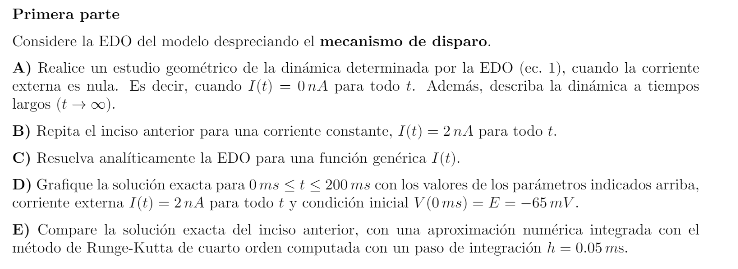

### C)

Resuelvo la ODE para $I(t) = I_0 = cte$:


\begin{eqnarray}
\frac{dV}{dt}
&=&
\frac{1}{\tau}
\left(
E-V(t)
+
RI_0
\right)
\end{eqnarray}

Uso el cambio de variable $W(t) = V(t) - E - R\, I_0$

\begin{eqnarray}
\frac{dW}{dt}
&=&-
\frac{1}{\tau}
W(t)
\end{eqnarray}

Cuya solución es:

$$ W(t) = W_0 \, e^{-t/\tau} $$

Por lo tanto...

$$ V(t) = W_0 \, e^{-t/\tau} +  E + R\, I_0 \text{ , con , } W_0 = V_0 - E - R\, I_0 $$


In [ ]:
p = V0, tau, E, R, I0 = [10e-3, 10e-3, -65e-3, 10e6 , 0]

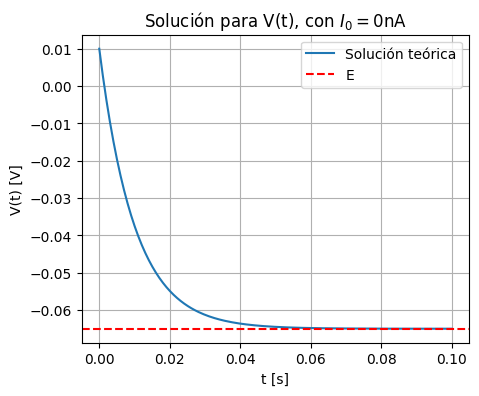

In [ ]:
# 2.1)
def V(t, p): # p = [V0, tau, E, R, I0]
  V0, tau, E, R, I0 = p
  W0 = V0  - E - R*I0
  return W0 * np.exp(-t/tau) + E + R*I0

t = np.linspace(0, 100e-3,200)

plt.figure(figsize=(5,4))

plt.plot(t,V(t,p), label = 'Solución teórica')
plt.axhline(E, ls = '--', c='r', label = 'E')
# plt.axhline(0, ls = '-.', c='black', label = 'V = 0')

plt.title(r'Solución para V(t), con $I_0 = $'+ f'{I0}nA')
plt.xlabel('t [s]')
plt.ylabel('V(t) [V]')
plt.grid()
plt.legend()

### A)

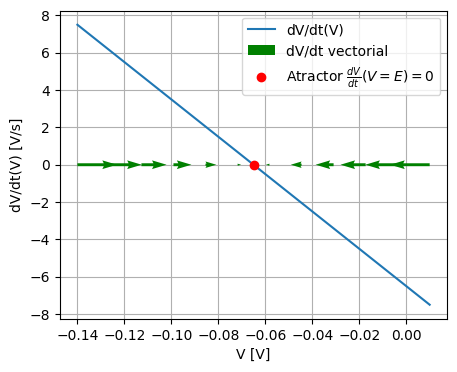

In [ ]:
#2.3 Diagrama de fase

def V_ode(V, t, p):
  V0, tau, E, R, I0 = p
  return  1/tau * (E - V + R*I0)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
plt.figure(figsize=(5,4))

xmax = V0
xmin = E-abs(V0-E)

t = np.linspace(0, 100e-3,200)
X = np.linspace(xmin,xmax,200)

plt.plot(X,V_ode(X, t, p), label = 'dV/dt(V)')
# plt.axhline(E, ls = '--', c='r', label = 'E')
# plt.axhline(0, ls = '-.', c='black', label = 'dV/dt = 0')

# Armo las flechitas vectoriales en Y=0
nro_flechas = 12
x_v = np.linspace(xmin,xmax, nro_flechas)
y_v = np.zeros(nro_flechas)
ux = V_ode(x_v, t, p)
uy =  np.zeros(nro_flechas)
plt.quiver(x_v, y_v, ux, uy,color='green',label='dV/dt vectorial', zorder = 10)

eq_idx = find_nearest(V_ode(X, t, p),0)
eq_X = X[eq_idx]
eq_Y = V_ode(X, t, p)[eq_idx]

plt.plot(eq_X , eq_Y ,'o', c = 'red', ms = 6, label = r'Atractor $\frac{dV}{dt}(V=E) = 0$')

# plt.title(r'Diagrama de fase para V(t), con $I_0 = ' + f'{I0}nA')
plt.xlabel('V [V]')
plt.ylabel('dV/dt(V) [V/s]')
plt.grid()
plt.legend()

El único punto de equilibrio es en $V=E$ es un punto atractor de equilibrio estable

### B)

Ahora uso $I_0 = 2nA$

In [ ]:
p = V0, tau, E, R, I0 = [10e-3, 10e-3, -65e-3, 10e6 , 2e-9]

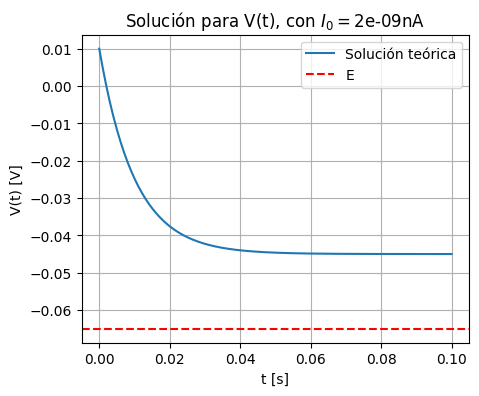

In [ ]:
# 2.1)
def V(t, p): # p = [V0, tau, E, R, I0]
  V0, tau, E, R, I0 = p
  W0 = V0  - E - R*I0
  return W0 * np.exp(-t/tau) + E + R*I0

t = np.linspace(0, 100e-3,200)

plt.figure(figsize=(5,4))

plt.plot(t,V(t,p), label = 'Solución teórica')
plt.axhline(E, ls = '--', c='r', label = 'E')
# plt.axhline(0, ls = '-.', c='black', label = 'V = 0')

plt.title(r'Solución para V(t), con $I_0 = $'+ f'{I0}nA')
plt.xlabel('t [s]')
plt.ylabel('V(t) [V]')
plt.grid()
plt.legend()

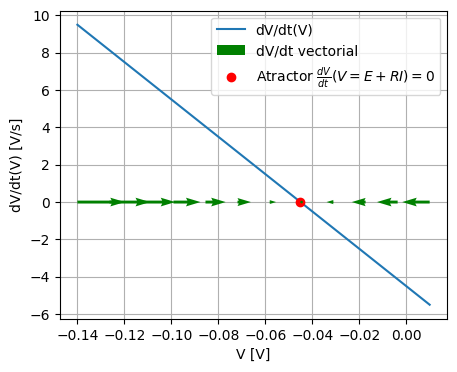

In [ ]:
#2.3 Diagrama de fase

def V_ode(V, t, p):
  V0, tau, E, R, I0 = p
  return  1/tau * (E - V + R*I0)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
plt.figure(figsize=(5,4))

xmax = V0
xmin = E-abs(V0-E)

t = np.linspace(0, 100e-3,200)
X = np.linspace(xmin,xmax,200)

plt.plot(X,V_ode(X, t, p), label = 'dV/dt(V)')
# plt.axhline(E, ls = '--', c='r', label = 'E')
# plt.axhline(0, ls = '-.', c='black', label = 'dV/dt = 0')

# Armo las flechitas vectoriales en Y=0
nro_flechas = 12
x_v = np.linspace(xmin,xmax, nro_flechas)
y_v = np.zeros(nro_flechas)
ux = V_ode(x_v, t, p)
uy =  np.zeros(nro_flechas)
plt.quiver(x_v, y_v, ux, uy,color='green',label='dV/dt vectorial', zorder = 10)

eq_idx = find_nearest(V_ode(X, t, p),0)
eq_X = X[eq_idx]
eq_Y = V_ode(X, t, p)[eq_idx]

plt.plot(eq_X , eq_Y ,'o', c = 'red', ms = 6, label = r'Atractor $\frac{dV}{dt}(V=E+RI) = 0$')

# plt.title(r'Diagrama de fase para V(t), con $I_0 = 2 nA $')#+ f'{I0}nA')
plt.xlabel('V [V]')
plt.ylabel('dV/dt(V) [V/s]')
plt.grid()
plt.legend()

### D)

Integraciones numéricas con $V_0 = E$

In [ ]:
p = V0, tau, E, R, I0 = [-65e-3, 10e-3, -65e-3, 10e6 , 2e-9]

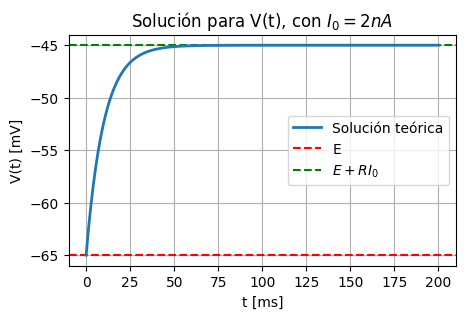

In [ ]:
t = np.linspace(0, 200e-3,300)

plt.figure(figsize=(5,3))
plt.plot(t*1000,V(t,p)*1000, label = 'Solución teórica',lw=2,zorder = 10)
plt.axhline(E*1000, ls = '--', c='r', label = 'E')
plt.axhline((E+I0*R)*1000, ls = '--', c='green', label = '$E+RI_0 $')
# plt.axhline(0, ls = '-.', c='black', label = 'V = 0')

plt.title(r'Solución para V(t), con $I_0 = 2nA$')
plt.xlabel('t [ms]')
plt.ylabel('V(t) [mV]')
plt.grid()
plt.legend()

Meto el Runge Kutta sobre esto

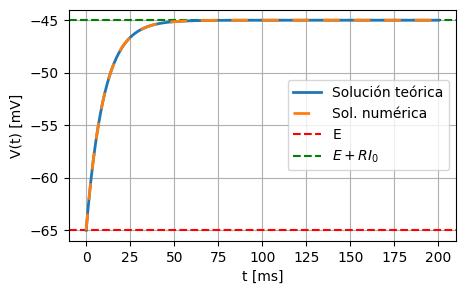

In [ ]:
t = np.linspace(0, 200e-3,300)

plt.figure(figsize=(5,3))

plt.plot(t*1000,V(t,p)*1000, label = 'Solución teórica',lw = 2,zorder = 10)

# p = V0, tau, E, R, I0 = [-65e-3, 10e-3, -65e-3, 10e6 , 2e-9]
# Vu = -50e-3
a,b = 0, 200e-3
dt = 0.05e-3
k = int((b-a)/dt)

ts, Xs = integrador_ode(V_ode, V0, a, b, k, p)
plt.plot(ts*1000,Xs*1000,  linestyle = (0, (6, 5)), label = 'Sol. numérica',lw = 2, zorder = 20)

plt.axhline(E*1000, ls = '--', c='r', label = 'E')
plt.axhline((E+I0*R)*1000, ls = '--', c='green', label = '$E+RI_0 $')
# plt.axhline(0, ls = '-.', c='black', label = 'V = 0')

# plt.title(r'Solución para V(t), con $I_0 = 2nA$')
plt.xlabel('t [ms]')
plt.ylabel('V(t) [mV]')
plt.grid()
plt.legend()

## Segunda parte


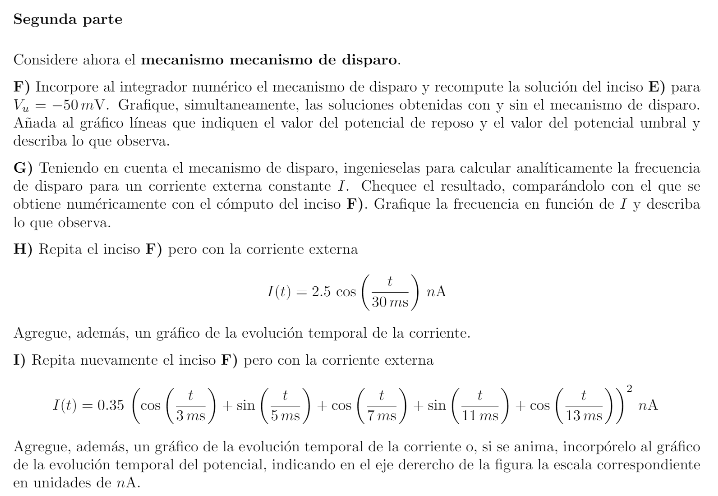

In [ ]:
def integrate_fire( f, X0, Vu, E, a, b, k, p=None, m=euler):
  '''
  Vu: potencial umbral
  E: potencial de reposo al que vuelve luego del disparo
  m: metodo que voy a usar (euler o rk4)
  f: funcion que da las derivadas de X
  a, b, k: tiempo inicial, final y nro de pasos intermedios
  p: parámetros que toma la función f
  '''
  if isinstance(X0, int) or isinstance(X0, float) : D=1
  else: D = X0.shape[0]            # Dimensión del problema

  dt = (b-a)/k               # Diferencial de tiempo entre soluciones
  ts = np.arange(a, k+1)*dt  # Tiempos donde calcularé la solución
  Xs = np.zeros((k+1, D))    # Solución aproximada
  Xs[0] = X0                 # Impongo la condición inicial a t=0
  for j in range(k):
    # Aplico metodo sobre Xs[j] para obtener Xs[j+1]
    Xs[j+1] = m(f, Xs[j], ts[j], dt, p)

    if Xs[j] >= Vu:
      Xs[j+1] = E

  return ts, Xs

### F)

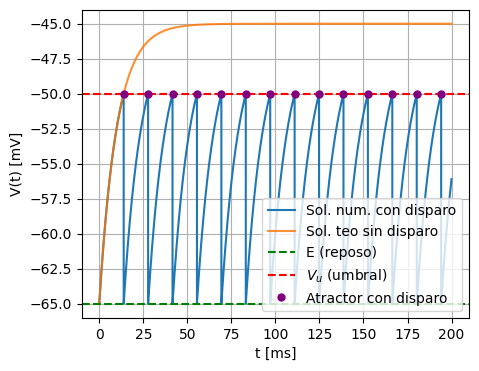

In [ ]:
# 3.1)
from scipy.signal import find_peaks

plt.figure(figsize=(5,4))
def V_ode(V, t, p):
  V0, tau, E, R, I0 = p
  return  1/tau * (E - V + R*I0)


p = V0, tau, E, R, I0 = [-65e-3, 10e-3, -65e-3, 10e6 , 2e-9]
Vu = -50e-3

a,b = 0, 200e-3
dt = 0.05e-4
k = int((b-a)/dt)

ts, Xs = integrate_fire(V_ode, V0, Vu, E, a, b, k, p )
plt.plot(ts*1000,Xs*1000, label = 'Sol. num. con disparo')

t = np.linspace(a,b,200)
plt.plot(t*1000,V(t,p)*1000, c= '#FF7400',label = 'Sol. teo sin disparo', alpha =0.8)

plt.axhline(E*1000, ls = '--', c='green', label = 'E (reposo)')
plt.axhline(Vu*1000, ls = '--', c='red', label = r'$V_u$ (umbral)')
# plt.axhline((E+R*I0)*1000, ls = '--', c='gray', label = 'Atractor sin disparo', zorder = 0)
# plt.axhline(0, ls = '-.', c='black', label = 'V = 0')

disparos_idx,_ = find_peaks(np.reshape(Xs, len(Xs)), height = -0.055)
plt.plot(ts[disparos_idx]*1000, Xs[disparos_idx]*1000,'o',ms=5, c= 'purple', label = 'Atractor con disparo')

# plt.title(r'Solución para V(t), con $I_0 = $'+ f'{I0}nA')
plt.xlabel('t [ms]')
plt.ylabel('V(t) [mV]')
plt.grid()
plt.legend(loc = 'lower right')

### G)

Periodo de disparo

Esto es equivalente a conocer el tiempo que tarda la neurona en llegar de $V_0$ a $V_u$ dados ciertos parametros

Se llega a que (ver hojita)

$$ t=-\tau \, ln\left[ \frac{1}{W_0} (V_u - E - R\,I_0)\right] $$

para nuestro caso este número es:


In [ ]:
def periodo_disparo(Vu, p):
  V0, tau, E, R, I0 = p
  W0 = V0  - E - R*I0
  return -tau * np.log(1/W0 * (Vu - E- R* I0))
print( f'El periodo de disparo teorico es: {1/periodo_disparo(Vu,p)}s')
print( f'El periodo de disparo numérico es: {1/np.mean(np.diff(ts[disparos_idx]))}s')

El periodo de disparo teorico es: 72.13475204444819s
El periodo de disparo numérico es: 72.12405337179949s


<ipython-input-15-62be5e60bc17>:31: RuntimeWarning: divide by zero encountered in log
  return -tau * np.log(1/W0 * (Vu - E- R* I0))


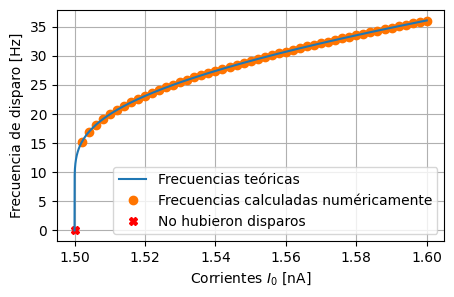

In [ ]:
# Ahora varío la corriente
#numerico

corrientes_num = np.linspace(1.5e-9, 1.6e-9,51)
# corrientes_num = np.geomspace(1.5e-9, 2e-9,50, base = 1e9)
plt.figure(figsize=(5,3))

frecuencias = []
for corr in corrientes_num:
  p = V0, tau, E, R, I0 = [-65e-3, 10e-3, -65e-3, 10e6 , corr]
  Vu = -50e-3

  a,b = 0, 200e-3
  dt = 0.05e-3
  k = int((b-a)/dt)

  ts, Xs = integrate_fire(V_ode, V0, Vu, E, a, b, k, p )

  disparos_idx,_ = find_peaks(np.reshape(Xs, len(Xs)), height = Vu)
  if len(ts[disparos_idx]) <= 1:
    frecuencias.append(0)
  else:
    frecuencias.append(1/np.mean(np.diff(ts[disparos_idx])))
frecuencias = np.array(frecuencias)

# teorico

def periodo_disparo(Vu,I0, p):
  V0, tau, E, R = p
  W0 = V0  - E - R*I0
  return -tau * np.log(1/W0 * (Vu - E- R* I0))

corrientes = np.linspace(1.5e-9, 1.6e-9,10000)

m = 1e9
plt.plot(corrientes*m,1/periodo_disparo(Vu,corrientes,p[:-1]) , label= 'Frecuencias teóricas', zorder = 10)
plt.plot(corrientes_num[1:]*m, frecuencias[1:], 'o',c='#FF7400', label= 'Frecuencias calculadas numéricamente')
plt.plot(corrientes_num[0]*m, frecuencias[0], 'X',c='red', label= 'No hubieron disparos')
# plt.title(r'Período de disparo en función de $I_0 $')
plt.xlabel(r'Corrientes $I_0$ [nA]')
plt.ylabel('Frecuencia de disparo [Hz]')
plt.grid()
plt.legend(loc = 'lower right')

### H)


Ahora I(t) es arbitrario

In [ ]:
def V_ode(V, t, p):
  V0, tau, E, R, I0 = p
  return  1/tau * (E - V + R*I(t,I0))

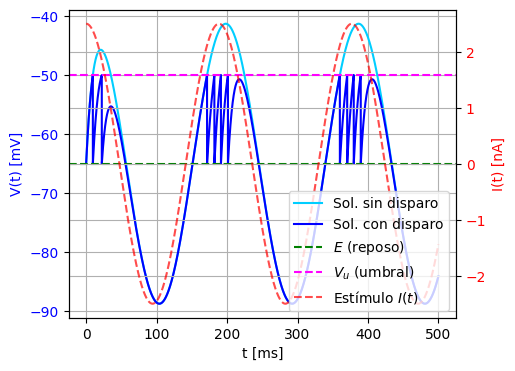

In [ ]:
def I(t, I0):
  return I0 * np.cos(t/30e-3)

fig, ax1 = plt.subplots(figsize = (5,4))
ax2 = ax1.twinx()

# setteo parámetros y CIs
p = V0, tau, E, R, I0 = [-65e-3, 10e-3, -65e-3, 10e6 , 2.5e-9]
Vu = -50e-3
a,b = 0, 500e-3
dt = 0.05e-3
k = int((b-a)/dt)

# Sol. num sin disparo
ts, Xs = integrador_ode(V_ode, V0, a, b, k, p )
ax1.plot(ts*1000,Xs *1000,c= '#00CEFF', label = 'Sol. sin disparo')


# Sol. num con disparo
ts, Xs = integrate_fire(V_ode, V0, Vu, E, a, b, k, p )
ax1.plot(ts*1000,Xs *1000,c='b', label = 'Sol. con disparo')
# # Atractores
# disparos_idx,_ = find_peaks(np.reshape(Xs, len(Xs)), height = Vu)
# ax1.plot(ts[disparos_idx], Xs[disparos_idx]*1000,'o', c= 'purple', label = 'V* con disparo', zorder = 10)


# Corriente en el otro ax

t = np.linspace(a,b,1000)
plt.plot(t*1000,I(t, I0)*1e9,'--',c ='r', label = r'Estímulo $I(t)$',alpha =0.7)



ax1.set_xlabel('t [ms]')
ax1.set_ylabel('V(t) [mV]', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.axhline(E *1000,linestyle='--',color='green',label='$E$ (reposo)')
ax1.axhline(Vu *1000,linestyle='--',color='magenta',label='$V_u$ (umbral)')
# ax1.axhline(atractor_B,linestyle='--',color='dodgerblue',label='Atractor V*')
ax1.grid()


# ax2.plot(t_num, 2.5e-9*np.cos(t_num/0.03), 'r-', label='I(t)')
ax2.set_ylabel('I(t) [nA]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax2.grid()
# Agregar una leyenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax2.legend(lines, labels, loc="lower right")


plt.show()

Voy a modificar $\tau$ a ver si afecta en el desfasaje entre I y V

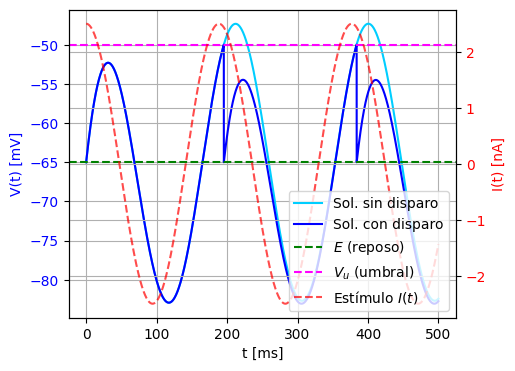

In [ ]:
def I(t, I0):
  return I0 * np.cos(t/30e-3)

fig, ax1 = plt.subplots(figsize = (5,4))
ax2 = ax1.twinx()

# setteo parámetros y CIs
p = V0, tau, E, R, I0 = [-65e-3, 30e-3, -65e-3, 10e6 , 2.5e-9]
Vu = -50e-3
a,b = 0, 500e-3
dt = 0.05e-3
k = int((b-a)/dt)

# Sol. num sin disparo
ts, Xs = integrador_ode(V_ode, V0, a, b, k, p )
ax1.plot(ts*1000,Xs *1000,c= '#00CEFF', label = 'Sol. sin disparo')


# Sol. num con disparo
ts, Xs = integrate_fire(V_ode, V0, Vu, E, a, b, k, p )
ax1.plot(ts*1000,Xs *1000,c='b', label = 'Sol. con disparo')
# # Atractores
# disparos_idx,_ = find_peaks(np.reshape(Xs, len(Xs)), height = Vu)
# ax1.plot(ts[disparos_idx], Xs[disparos_idx]*1000,'o', c= 'purple', label = 'V* con disparo', zorder = 10)


# Corriente en el otro ax

t = np.linspace(a,b,1000)
plt.plot(t*1000,I(t, I0)*1e9,'--',c ='r', label = r'Estímulo $I(t)$',alpha =0.7)



ax1.set_xlabel('t [ms]')
ax1.set_ylabel('V(t) [mV]', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.axhline(E *1000,linestyle='--',color='green',label='$E$ (reposo)')
ax1.axhline(Vu *1000,linestyle='--',color='magenta',label='$V_u$ (umbral)')
# ax1.axhline(atractor_B,linestyle='--',color='dodgerblue',label='Atractor V*')
ax1.grid()


# ax2.plot(t_num, 2.5e-9*np.cos(t_num/0.03), 'r-', label='I(t)')
ax2.set_ylabel('I(t) [nA]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax2.grid()
# Agregar una leyenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax2.legend(lines, labels, loc="lower right")


plt.show()

Efectivamente vemos como se desfasan las curvas

### I)

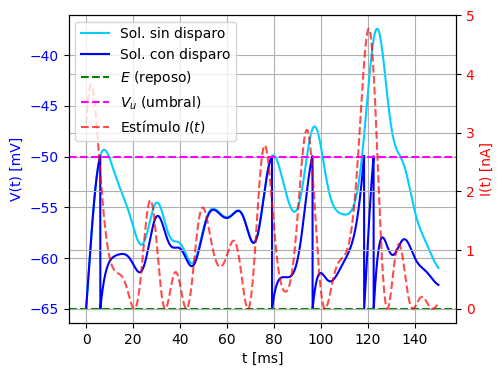

In [ ]:
def I(t, I0):
  return I0 * ( np.cos(t/3e-3)+ np.sin(t/5e-3) +np.cos(t/7e-3)+ np.sin(t/11e-3)+ np.cos(t/13e-3))**2

fig, ax1 = plt.subplots(figsize = (5,4))
ax2 = ax1.twinx()

# setteo parámetros y CIs

p = V0, tau, E, R, I0 = [-65e-3, 10e-3, -65e-3, 10e6 , 0.35e-9]
Vu = -50e-3
a,b = 0, 150e-3
dt = 0.05e-3
k = int((b-a)/dt)

# Sol. num sin disparo
ts, Xs = integrador_ode(V_ode, V0, a, b, k, p )
ax1.plot(ts*1000,Xs *1000,c= '#00CEFF', label = 'Sol. sin disparo')


# Sol. num con disparo
ts, Xs = integrate_fire(V_ode, V0, Vu, E, a, b, k, p )
ax1.plot(ts*1000,Xs *1000,c='b', label = 'Sol. con disparo')


# Corriente en el otro ax

t = np.linspace(a,b,1000)
plt.plot(t*1000,I(t, I0)*1e9,'--',c ='r', label = r'Estímulo $I(t)$',alpha =0.7)



ax1.set_xlabel('t [ms]')
ax1.set_ylabel('V(t) [mV]', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.axhline(E *1000,linestyle='--',color='green',label='$E$ (reposo)')
ax1.axhline(Vu *1000,linestyle='--',color='magenta',label='$V_u$ (umbral)')
# ax1.axhline(atractor_B,linestyle='--',color='dodgerblue',label='Atractor V*')
ax1.grid()


# ax2.plot(t_num, 2.5e-9*np.cos(t_num/0.03), 'r-', label='I(t)')
ax2.set_ylabel('I(t) [nA]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax2.grid()
# Agregar una leyenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax2.legend(lines, labels, loc='upper left')


plt.show()